For this question, you are expected to work with the CIFAR-10 dataset. The CIFAR-10 dataset
consists of 60,000 32x32 RGB images of 10 classes, with 6,000 images per class. You are
expected to work with 3 classes from the available classes as per your choice. Hence, you
should have roughly 18,000 images in your training curated dataset, with 15,000 images
in the train and 3,000 in the test dataset, respectively. (Note: No additional marks will
be provided for working with more classes than required.)

In [1]:
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as funct
from torchvision import datasets , transforms
from torch.utils.data import DataLoader , Subset
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score , accuracy_score , confusion_matrix , ConfusionMatrixDisplay
from torchvision.datasets import CIFAR10 
import matplotlib.pyplot as plt
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
import os

Data Preparation: Use PyTorch to load the CIFAR-10 dataset, perform a
stratified random split in the ratio of 0.8:0.2 for the training and validation datasets.
Here, the 15,000 images from the training dataset are split into train-val via 0.8:0.2
split, and 3,000 images (1,000 per class) are retained as the testing data from the
original test dataset of CIFAR-10. Create a custom Dataset class for the data and
create data loaders for all the dataset splits - train, val, and test.

In [2]:
transformer = transforms.Compose([transforms.ToTensor()])
cifar10Train = datasets.CIFAR10(root='./data' ,train=True , download=True , transform=transformer)
cifar10Test = datasets.CIFAR10(root='./data' , train = False ,download=True , transform=transformer)
classesTaken = [0,1,2]
trainidxes = [] ; testidxes = []
for i , (x,y) in enumerate(cifar10Train):
    if y in classesTaken:
        trainidxes.append(i)
for i , (x,y) in enumerate(cifar10Test):
    if y in classesTaken:
        testidxes.append(i)
TrainDataset = Subset(cifar10Train , trainidxes) ; TestDataset = Subset(cifar10Test , testidxes)
labelForTrain = [TrainDataset.dataset.targets[i] for i in TrainDataset.indices]
trainIndices , valIndices = train_test_split(np.arange(len(TrainDataset)) , test_size=0.2 , stratify=labelForTrain,random_state=42)
TrainDatasetSub = Subset(TrainDataset , trainIndices) ; valDatasetSub = Subset(TrainDataset , valIndices)
class customDataset(torch.utils.data.Dataset):
    def __init__(self , subset):
        self.subset = subset
    def __len__(self):
        return len(self.subset)
    def __getitem__(self , idx):
        return self.subset[idx]
TrainDataset = customDataset(TrainDatasetSub) ; ValDataset = customDataset(valDatasetSub) ; TestDataset = customDataset(TestDataset)
batch = 64
trainLoad = DataLoader(TrainDataset , batch_size=batch , shuffle=True , num_workers=2)
valLoad = DataLoader(ValDataset , batch_size=batch , shuffle=False , num_workers=2)
testLoad = DataLoader(TestDataset, batch_size = batch , shuffle= False , num_workers=2)

100%|██████████| 170498071/170498071 [00:02<00:00, 64522453.51it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Visualization: Load the dataset and visualize 5 images of each class
from both the training and validation datasets.

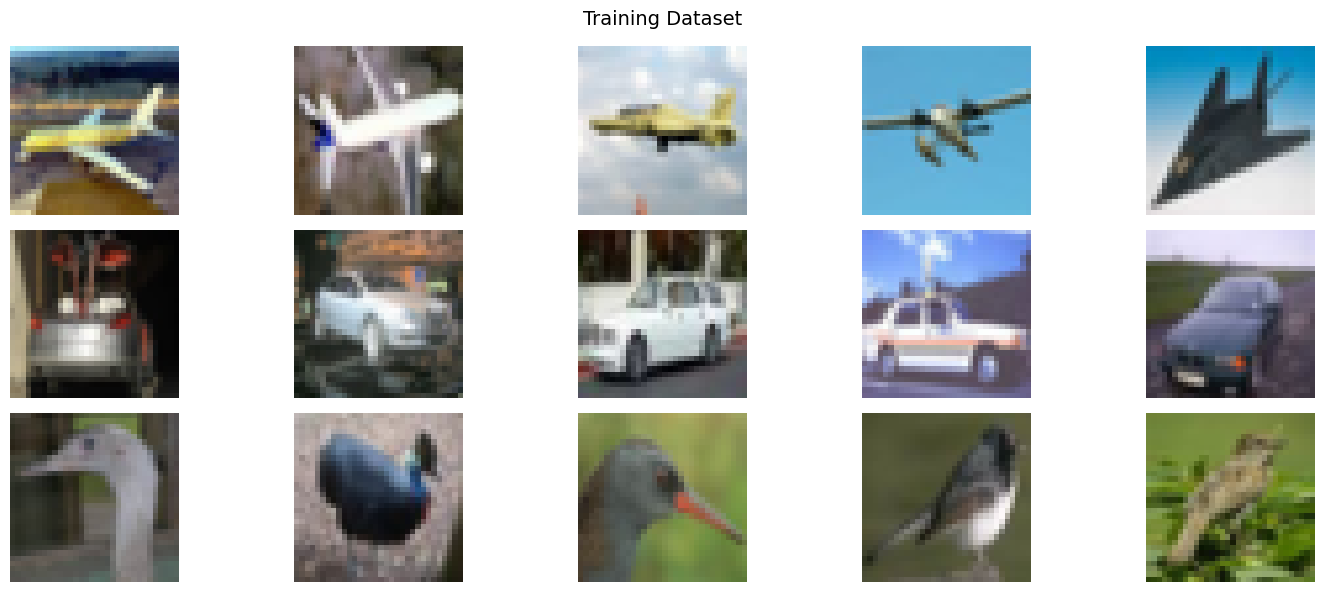

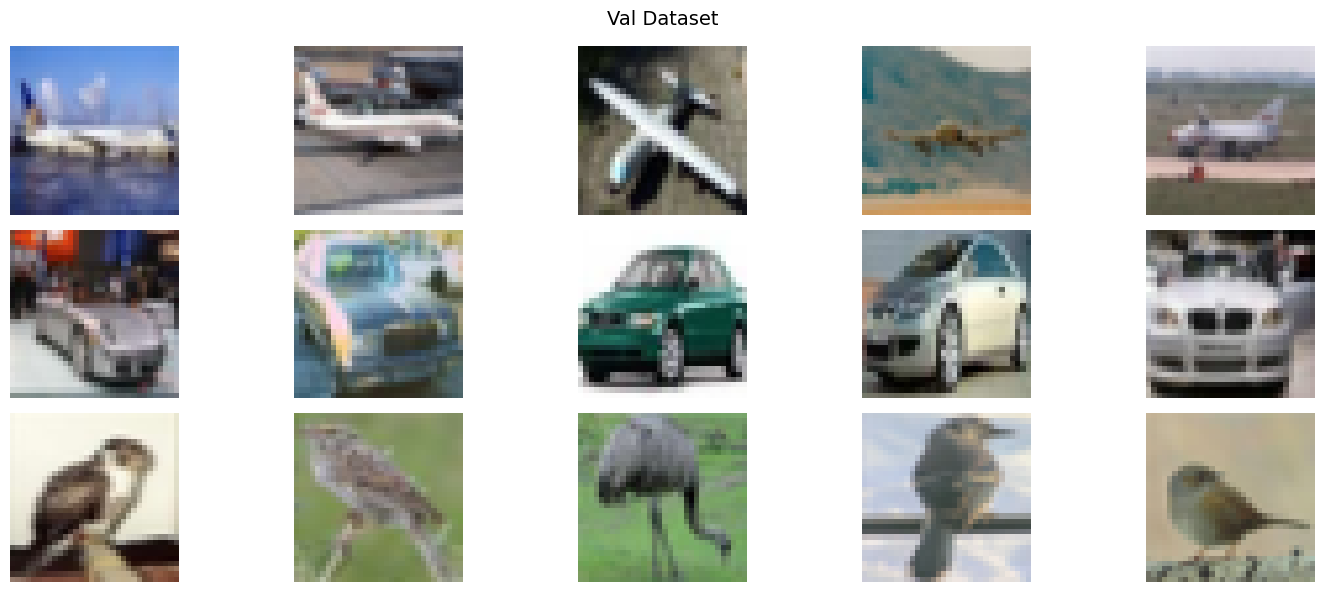

In [3]:
def imgviz(loader , classesTaken , typeval):
    storeimg = {i : [] for i in classesTaken}
    for limg , llab in loader:
        for img , lab in zip(limg , llab):
            lab = lab.item()
            if len(storeimg[lab]) < 5 and lab in classesTaken:
                storeimg[lab].append(img)
        if storeimg[0] == 5 and storeimg[1] == 5 and storeimg[2] == 5:
            break
    fig , axes = plt.subplots(3 , 5 , figsize = (15 , 6))
    fig.suptitle(typeval , fontsize = 14)
    for i , classval in enumerate(classesTaken):
        for j , img in enumerate(storeimg[classval]):
            axe = axes[i , j]
            img = img.permute(1 , 2 ,0)
            axe.imshow(img.numpy())
            axe.axis('off')
        axes[i,0].set_ylabel(f'Class {classval}' , rotation = 0 , size = 'large' , labelpad = 30)
    plt.tight_layout()
    plt.show()
imgviz(trainLoad , classesTaken , "Training Dataset")
imgviz(valLoad , classesTaken , "Val Dataset")

CNN Implementation: Create a CNN architecture with 2 convolutional
layers (using in-built PyTorch implementations) having a kernel size of 5 x 5, 16
channels, padding and stride of 1 for the first layer, and kernel size of 3 x 3, 32
channels, stride of 1, and padding of 0 for the second layer. Use max-pooling layers
with a kernel size of 3 x 3 with a stride of 2 after the first convolutional layer
and a kernel size of 3 x 3 with stride 3 after the second convolutional layer. After
the second max pooling layer, flatten out the output and add it to a multi-layer
perceptron, with 16 neurons in the first layer and the classification head as the
second layer. Use the ReLU activation function after each layer other than the last
layer (the classification head layer).

In [4]:
class CNN(nn.Module):
    def __init__(self , cntClass):
        super(CNN , self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3 , out_channels=16 , kernel_size=5 , stride=1 , padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=3 , stride= 2)
        self.conv2 = nn.Conv2d(in_channels=16 , out_channels=32 , kernel_size=3 , stride=1 , padding=0)
        self.pool2 = nn.MaxPool2d(kernel_size= 3  , stride = 3)
        self.fc1 = nn.Linear(32*3*3 , 16)
        self.fc2 = nn.Linear(16 , cntClass)
        self.relu = nn.ReLU()
        tempinp = torch.zeros(1 , 3 , 32 , 32)
        x = self.pool1(self.relu(self.conv1(tempinp)))
        x = self.pool2(self.relu(self.conv2(x)))
        flatsz = x.view(-1).shape[0]
        self.fc1 = nn.Linear(flatsz , 16)
        self.fc2 = nn.Linear(16 , cntClass)
    def forward(self , x):
        x = self.pool1(self.relu(self.conv1(x)))
        x= self.pool2(self.relu(self.conv2(x)))
        x = torch.flatten(x , start_dim=1)
        x = self.relu(self.fc1(x))
        x= self.fc2(x)
        return x

Training the model: Train the model using the cross-entropy loss function with Adam optimizer for 15 epochs. Log the training and validation loss and
accuracy after each epoch. Save the trained models as .pth files, which are to be
submitted along with the code for the assignment.

In [5]:
cnnModel = CNN(3)
optimizer = Adam(cnnModel.parameters() , lr=0.001)
entr = CrossEntropyLoss()
trainLossStore = [] ; valLossStore = [] ; trainAccuracyStore = [] ; valAccuracyStore = []
for i in range(15):
    cnnModel.train()
    totloss = 0.0 ; cnt1 = 0 ; tot = 0
    for img,  lab in trainLoad:
        optimizer.zero_grad()
        outputs = cnnModel(img)
        loss = entr(outputs , lab)
        loss.backward() ; optimizer.step()
        totloss += loss.item()
        u , predicted = torch.max(outputs , 1)
        tot += lab.size(0)
        cnt1 += (predicted == lab).sum().item()
    trainLoss = totloss/len(trainLoad) ; trainaccuracy = 100*cnt1/tot
    trainLossStore.append(trainLoss) ; trainAccuracyStore.append(trainaccuracy)
    cnnModel.eval()
    valLoss = 0.0 ; valcnt1 =0 ; valtot = 0
    with torch.no_grad():
        for img , lab in valLoad:
            outputs = cnnModel(img)
            loss = entr(outputs , lab)
            valLoss += loss.item()
            u , predicted = torch.max(outputs ,1)
            valtot += lab.size(0) ; valcnt1 += (predicted == lab).sum().item()
    valLoss = valLoss/len(valLoad) ; valLossStore.append(valLoss)
    valAcc = 100*valcnt1/valtot  ; valAccuracyStore.append(valAcc)
    print(f'Epoch [{i+1}/15] , train loss: {trainLoss:.4f} , train accuracy: {trainaccuracy:.4f} , val loss: {valLoss:.4f} , val accuracy: {valAcc:.4f}')

torch.save(cnnModel.state_dict() , "cnnModel.pth")

Epoch [1/15] , train loss: 0.8532 , train accuracy: 60.0667 , val loss: 0.7179 , val accuracy: 68.4667
Epoch [2/15] , train loss: 0.5938 , train accuracy: 76.4333 , val loss: 0.5785 , val accuracy: 77.4333
Epoch [3/15] , train loss: 0.5372 , train accuracy: 78.5083 , val loss: 0.5283 , val accuracy: 79.0333
Epoch [4/15] , train loss: 0.4985 , train accuracy: 79.9667 , val loss: 0.5041 , val accuracy: 79.9667
Epoch [5/15] , train loss: 0.4730 , train accuracy: 81.1833 , val loss: 0.4683 , val accuracy: 81.8667
Epoch [6/15] , train loss: 0.4511 , train accuracy: 82.1833 , val loss: 0.4751 , val accuracy: 80.4000
Epoch [7/15] , train loss: 0.4245 , train accuracy: 83.2750 , val loss: 0.4803 , val accuracy: 80.4333
Epoch [8/15] , train loss: 0.4061 , train accuracy: 84.2000 , val loss: 0.4197 , val accuracy: 83.5333
Epoch [9/15] , train loss: 0.3902 , train accuracy: 84.6583 , val loss: 0.4135 , val accuracy: 83.1667
Epoch [10/15] , train loss: 0.3795 , train accuracy: 85.1000 , val loss: 

Testing: Observe the training and validation plots for loss and accuracy
and comment on your understanding of the results. Report the accuracy and F1-
score on the test dataset. Plot the confusion matrix for the train, val and test
dataset.

16


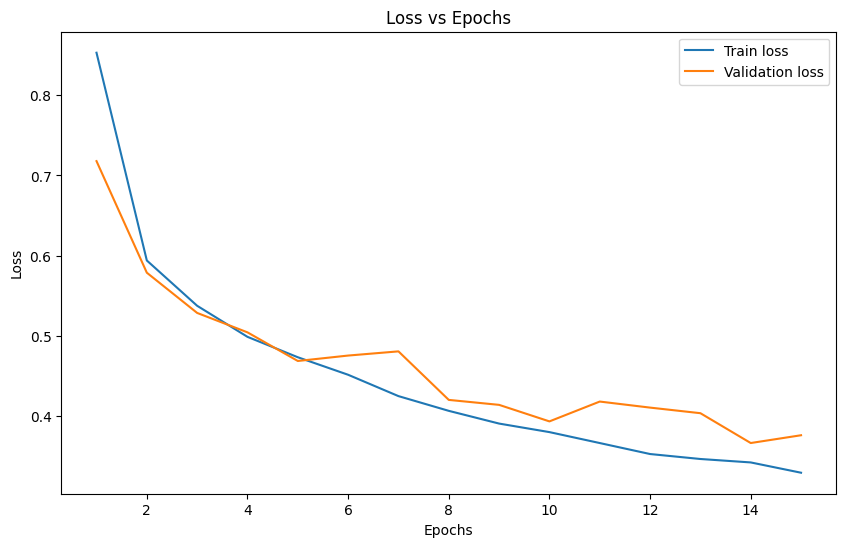

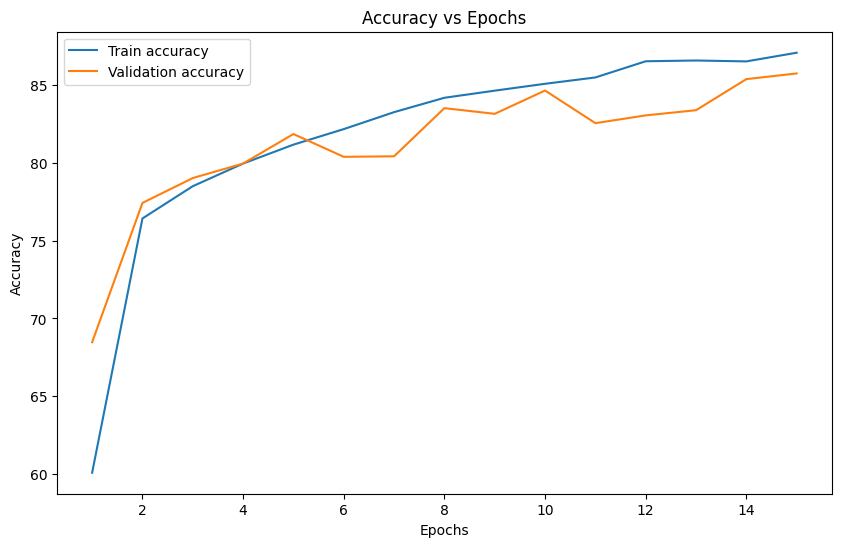

In [6]:
plt.figure(figsize = (10,6))
print(len(trainLossStore) + 1)
plt.plot(range(1 , len(trainLossStore) + 1) , trainLossStore , label = 'Train loss')
plt.plot(range(1 , len(valLossStore) + 1) , valLossStore, label = 'Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')
plt.legend()
plt.show()
plt.figure(figsize = (10,6))
plt.plot(range(1 , len(trainAccuracyStore) + 1) , trainAccuracyStore , label = 'Train accuracy')
plt.plot(range(1 , len(valAccuracyStore) + 1) , valAccuracyStore, label = 'Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epochs')
plt.legend()
plt.show()

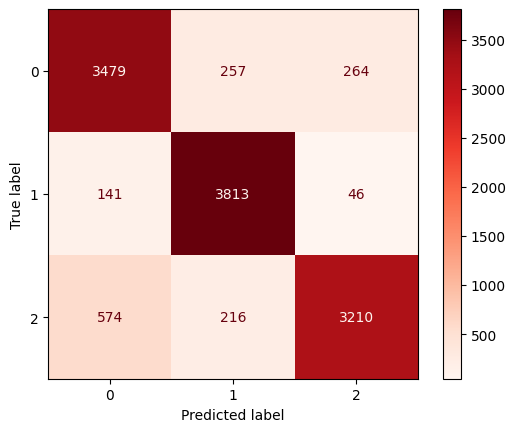

In [7]:
testTruth = [] ; testPred = []
cnnModel.eval()
with torch.no_grad():
    for img , lab in trainLoad:
        outputs = cnnModel(img)
        u , pred = torch.max(outputs , 1)
        testTruth.extend(lab.cpu().numpy()) ; testPred.extend(pred.cpu().numpy())
valconf = (confusion_matrix(testTruth , testPred))
ConfusionMatrixDisplay(confusion_matrix=valconf , display_labels=classesTaken).plot(cmap= "Reds")

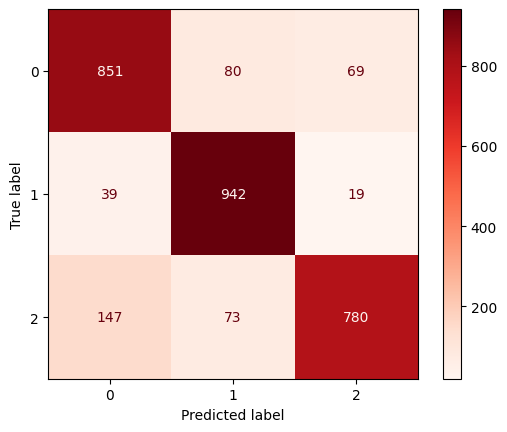

In [8]:
testTruth = [] ; testPred = []
cnnModel.eval()
with torch.no_grad():
    for img , lab in valLoad:
        outputs = cnnModel(img)
        u , pred = torch.max(outputs , 1)
        testTruth.extend(lab.cpu().numpy()) ; testPred.extend(pred.cpu().numpy())
testAcc = accuracy_score(testTruth , testPred)*100; testF1 = f1_score(testTruth , testPred , average='weighted')
valconf = (confusion_matrix(testTruth , testPred))
ConfusionMatrixDisplay(confusion_matrix=valconf , display_labels=classesTaken).plot(cmap= "Reds")

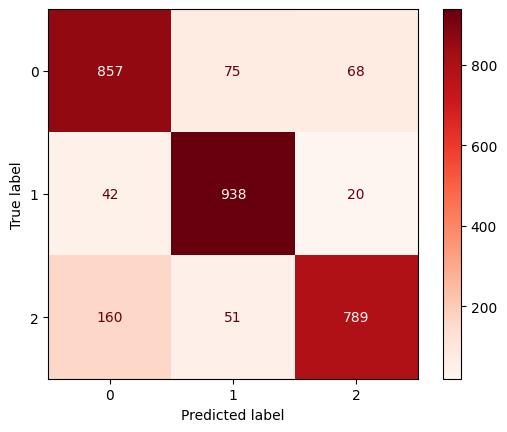

In [9]:
testTruth = [] ; testPred = []
cnnModel.eval()
with torch.no_grad():
    for img , lab in testLoad:
        outputs = cnnModel(img)
        u , pred = torch.max(outputs , 1)
        testTruth.extend(lab.cpu().numpy()) ; testPred.extend(pred.cpu().numpy())
testAcc = accuracy_score(testTruth , testPred)*100; testF1 = f1_score(testTruth , testPred , average='weighted')
valconf = (confusion_matrix(testTruth , testPred))
ConfusionMatrixDisplay(confusion_matrix=valconf , display_labels=classesTaken).plot(cmap= "Reds")

In [10]:
testAcc = accuracy_score(testTruth , testPred)*100; testF1 = f1_score(testTruth , testPred , average='weighted')
print(f'Test accuracy:{testAcc:.4f}')
print(f'Test F1-score:{testF1:.4f}')

Test accuracy:86.1333
Test F1-score:0.8607


Training an MLP: Create an MLP model with 2 fully connected layers,
the first layer with 64 neurons and the second layer as the classification head.
Flatten out the image before processing it into the MLP. Use a ReLU layer after
the first fully connected layer, and use the cross-entropy loss function with adam
optimizer to train the model for 15 epochs. Log the training and validation loss and
accuracy after each epoch. Save the models as .pth files, which must be submitted
along with the assignment.

The train , val and test accuracy and loss with the stored model are as follows:

In [11]:
cnnModel = CNN(3)
cnnModel.load_state_dict(torch.load("cnnModel.pth", weights_only = True))
cnnModel.eval() ; entr = CrossEntropyLoss()
def calc(loader):
    totalLoss = 0.0 ; cnt1 = 0; tot = 0;
    with torch.no_grad():
        for img , lab in loader:
            outputs = cnnModel(img)
            loss = entr(outputs , lab) ; totalLoss += loss.item()
            u , pred = torch.max(outputs , 1)
            tot += lab.size(0)
            cnt1 += (pred == lab).sum().item()
    lossval = totalLoss/len(loader) ; acc = 100*cnt1/tot
    return lossval , acc
trainLoss , trainAcc = calc(trainLoad) ; valLoss , valAcc = calc(valLoad); testLoss , testAcc = calc(testLoad)
print(f'Train Loss:{trainLoss} , Train Acc: {trainAcc}')
print(f'Val Loss:{valLoss} , Val Acc: {valAcc}')
print(f'Test Loss:{testLoss} , Test Acc: {testAcc}')

Train Loss:0.3226033648911943 , Train Acc: 87.51666666666667
Val Loss:0.3755923826643761 , Val Acc: 85.76666666666667
Test Loss:0.3641480372307148 , Test Acc: 86.13333333333334


In [12]:
class MLP(nn.Module):
    def __init__(self , inputsz , cntClasses):
        super(MLP , self).__init__()
        self.fc1 = nn.Linear(inputsz , 64)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(64 , cntClasses)
    def forward(self , x):
        x = x.view(x.size(0) , -1)
        x= self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

In [13]:
inputsz = 32*32*3 ;
mlpModel = MLP(inputsz , 3)
optimizer = Adam(mlpModel.parameters() , lr = 0.001)
entr = CrossEntropyLoss()
trainLossStore = [] ; valLossStore = [] ; trainAccurStore = [] ; valAccurStore = []
for i in range(15):
    mlpModel.train()
    totLoss = 0.0 ; cnt1 = 0 ; tot = 0
    for img , lab in trainLoad:
        optimizer.zero_grad()
        outputs = mlpModel(img)
        loss = entr(outputs , lab)
        loss.backward() ; optimizer.step()
        totLoss += loss.item()
        u , pred = torch.max(outputs , 1)
        tot+=lab.size(0)
        cnt1 += (pred == lab).sum().item()
    trainLoss = totLoss/len(trainLoad)
    trainacc = 100*cnt1/tot
    trainLossStore.append(trainLoss)
    trainAccurStore.append(trainacc)
    mlpModel.eval()
    valLoss = 0.0 ; valcnt1 = 0 ; valtot = 0
    with torch.no_grad():
        for img , lab in valLoad:
            outputs = mlpModel(img)
            loss = entr(outputs , lab) ; valLoss += loss.item()
            u , pred = torch.max(outputs ,1)
            valtot+=lab.size(0)
            valcnt1 += (pred == lab).sum().item()
    valLoss = valLoss/len(valLoad)
    valAcc = 100*valcnt1/valtot
    valLossStore.append(valLoss)
    valAccurStore.append(valAcc)
    print(f'Epoch [{i+1}/15] , train loss: {trainLoss:.4f} , train accuracy: {trainacc:.4f} , val loss: {valLoss:.4f} , val accuracy: {valAcc:.4f}')
torch.save(mlpModel.state_dict() , "mlpModel.pth")

Epoch [1/15] , train loss: 0.8455 , train accuracy: 62.9333 , val loss: 0.7920 , val accuracy: 67.2000
Epoch [2/15] , train loss: 0.7493 , train accuracy: 68.4250 , val loss: 0.7277 , val accuracy: 71.8667
Epoch [3/15] , train loss: 0.7018 , train accuracy: 71.1250 , val loss: 0.7054 , val accuracy: 73.0667
Epoch [4/15] , train loss: 0.6859 , train accuracy: 71.2583 , val loss: 0.7040 , val accuracy: 71.9333
Epoch [5/15] , train loss: 0.6657 , train accuracy: 72.1667 , val loss: 0.6830 , val accuracy: 73.1333
Epoch [6/15] , train loss: 0.6431 , train accuracy: 73.8417 , val loss: 0.6877 , val accuracy: 73.2333
Epoch [7/15] , train loss: 0.6284 , train accuracy: 74.3333 , val loss: 0.6518 , val accuracy: 74.7667
Epoch [8/15] , train loss: 0.6068 , train accuracy: 75.5917 , val loss: 0.6392 , val accuracy: 75.1000
Epoch [9/15] , train loss: 0.5974 , train accuracy: 75.8667 , val loss: 0.6452 , val accuracy: 73.9000
Epoch [10/15] , train loss: 0.5777 , train accuracy: 76.7917 , val loss: 

Infer and Compare: Compute the test accuracy and F1-score and plot the
confusion matrix for the MLP model. Now, compare the results and plots obtained
from both the models and comment on their performance and differences.

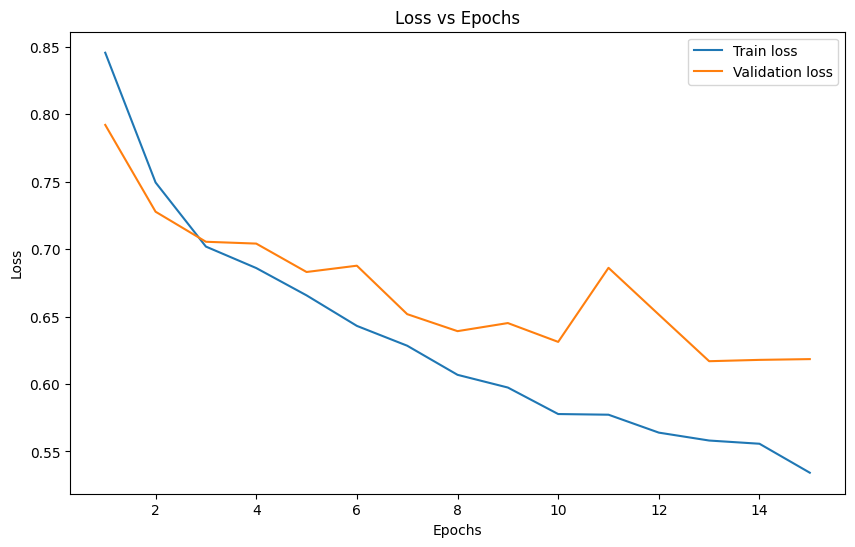

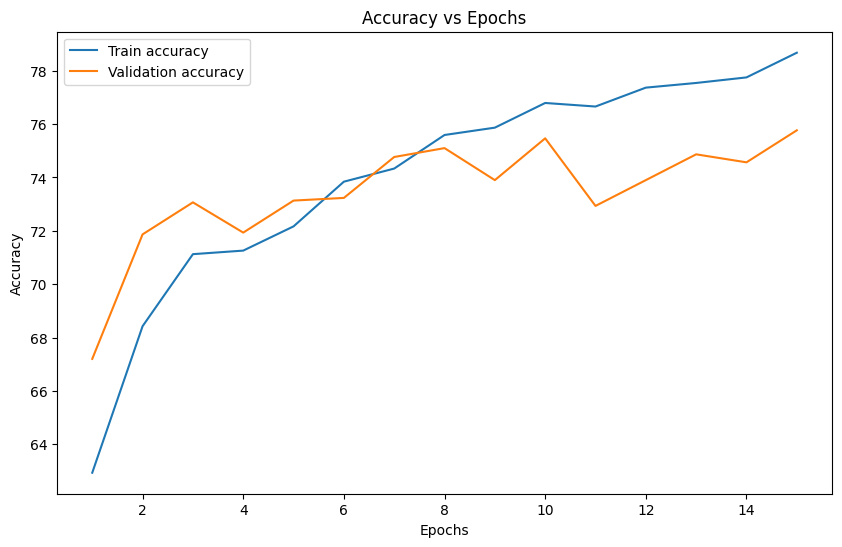

In [14]:
plt.figure(figsize = (10,6))
plt.plot(range(1 , len(trainLossStore) + 1) , trainLossStore , label = 'Train loss')
plt.plot(range(1 , len(valLossStore) + 1) , valLossStore, label = 'Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')
plt.legend()
plt.show()
plt.figure(figsize = (10,6))
plt.plot(range(1 , len(trainAccurStore) + 1) , trainAccurStore , label = 'Train accuracy')
plt.plot(range(1 , len(valAccurStore) + 1) , valAccurStore, label = 'Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epochs')
plt.legend()
plt.show()

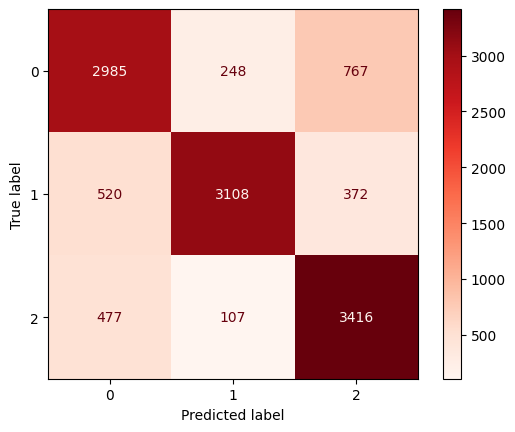

In [15]:
testTruth = [] ; testPred = []
mlpModel.eval()
with torch.no_grad():
    for img , lab in trainLoad:
        outputs = mlpModel(img)
        u , pred = torch.max(outputs , 1)
        testTruth.extend(lab.cpu().numpy()) ; testPred.extend(pred.cpu().numpy())
valconf = (confusion_matrix(testTruth , testPred))
ConfusionMatrixDisplay(confusion_matrix=valconf , display_labels=classesTaken).plot(cmap= "Reds")

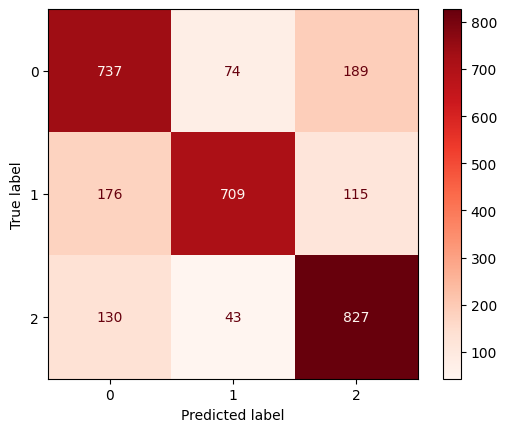

In [16]:
testTruth = [] ; testPred = []
mlpModel.eval()
with torch.no_grad():
    for img , lab in valLoad:
        outputs = mlpModel(img)
        u , pred = torch.max(outputs , 1)
        testTruth.extend(lab.cpu().numpy()) ; testPred.extend(pred.cpu().numpy())
valconf = (confusion_matrix(testTruth , testPred))
ConfusionMatrixDisplay(confusion_matrix=valconf , display_labels=classesTaken).plot(cmap= "Reds")

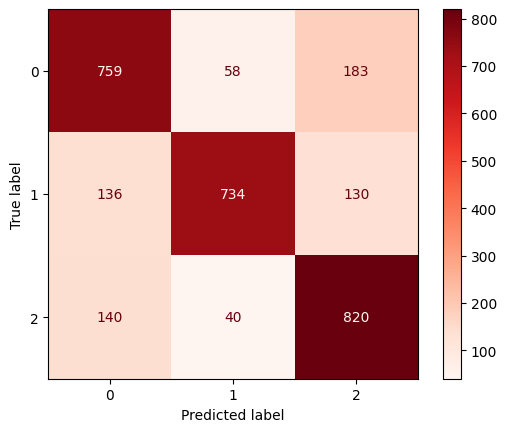

In [17]:
testTruth = [] ; testPred = []
mlpModel.eval()
with torch.no_grad():
    for img , lab in testLoad:
        outputs = mlpModel(img)
        u , pred = torch.max(outputs , 1)
        testTruth.extend(lab.cpu().numpy()) ; testPred.extend(pred.cpu().numpy())
valconf = (confusion_matrix(testTruth , testPred))
ConfusionMatrixDisplay(confusion_matrix=valconf , display_labels=classesTaken).plot(cmap= "Reds")

In [18]:
testAcc = accuracy_score(testTruth , testPred)*100 ; testF1 = f1_score(testTruth , testPred , average='weighted')
print(f'Test accuracy:{testAcc:.4f}')
print(f'Test F1-score:{testF1:.4f}')

Test accuracy:77.1000
Test F1-score:0.7720


The train , val and test accuracy and loss with the stored model are as follows:

In [19]:
inputsz = 32*32*3 ;
mlpModel = MLP(inputsz , 3)
mlpModel.load_state_dict(torch.load("mlpModel.pth", weights_only = True))
mlpModel.eval() ; entr = CrossEntropyLoss()
def calc(loader):
    totalLoss = 0.0 ; cnt1 = 0; tot = 0;
    with torch.no_grad():
        for img , lab in loader:
            outputs = mlpModel(img)
            loss = entr(outputs , lab) ; totalLoss += loss.item()
            u , pred = torch.max(outputs , 1)
            tot += lab.size(0)
            cnt1 += (pred == lab).sum().item()
    lossval = totalLoss/len(loader) ; acc = 100*cnt1/tot
    return lossval , acc
trainLoss , trainAcc = calc(trainLoad) ; valLoss , valAcc = calc(valLoad); testLoss , testAcc = calc(testLoad)
print(f'Train Loss:{trainLoss} , Train Acc: {trainAcc}')
print(f'Val Loss:{valLoss} , Val Acc: {valAcc}')
print(f'Test Loss:{testLoss} , Test Acc: {testAcc}')

Train Loss:0.5200013221895441 , Train Acc: 79.24166666666666
Val Loss:0.6184400294689422 , Val Acc: 75.76666666666667
Test Loss:0.592272476312962 , Test Acc: 77.1
